### raw data
* word embedding: glove
* doc text: ./data/IMDB.txt

### dataset
1. IMDB
2. CNNNews
3. [PubMed](https://github.com/LIAAD/KeywordExtractor-Datasets/blob/master/datasets/PubMed.zip)

### preprocess
1. filter too frequent and less frequent words
2. stemming
3. document vector aggregation

### model
1. TopK
2. Sklearn
3. Our model

### evaluation
1. F1
2. NDCG

In [42]:
from collections import defaultdict
import math
import numpy as np 
import re
import torch
import torch.nn as nn
from itertools import cycle
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR
from tqdm.auto import tqdm

# Used to get the data
from sklearn.metrics import ndcg_score

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')

import matplotlib.pyplot as plt 
import pandas as pd

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/chrisliu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Preprocess config

In [2]:
config = {}

config["dataset"] = "IMDB" # "IMDB" "CNN", "PubMed"
config["n_document"] = 100
config["min_word_freq_threshold"] = 20
config["topk_word_freq_threshold"] = 300
config["document_vector_agg_weight"] = 'uniform' # ['mean', 'IDF', 'uniform', 'gaussian', 'exponential']
config["select_topk_TFIDF"] = None


In [3]:
# load word embedding
embedding_file = "../data/glove.6B.100d.txt"

word2embedding = dict()
word_dim = int(re.findall(r".(\d+)d",embedding_file)[0])

with open(embedding_file,"r") as f:
    for line in tqdm(f):
        line = line.strip().split()
        word = line[0]
        embedding = list(map(float,line[1:]))
        word2embedding[word] = embedding

print("Number of words:%d" % len(word2embedding))

0it [00:00, ?it/s]

Number of words:400000


In [4]:
class Vocabulary:
    def __init__(self, word2embedding, min_word_freq_threshold=0, topk_word_freq_threshold=0):
        # The low frequency words will be assigned as <UNK> token
        self.itos = {0: "<UNK>"}
        self.stoi = {"<UNK>": 0}
        
        self.word2embedding = word2embedding
        self.min_word_freq_threshold = min_word_freq_threshold
        self.topk_word_freq_threshold = topk_word_freq_threshold
        
        self.word_freq_in_corpus = defaultdict(int)
        self.IDF = {}
        self.ps = PorterStemmer()
        self.stop_words = set(stopwords.words('english'))

    def __len__(self):
        return len(self.itos)

#     @staticmethod
    def tokenizer_eng(self, text):
        text = re.sub(r'[^A-Za-z0-9 ]+', '', text)
        text = text.strip().split()
        
        return [self.ps.stem(w) for w in text if w.lower() not in self.stop_words]

    def build_vocabulary(self, sentence_list):
        self.doc_freq = defaultdict(int) # # of document a word appear
        self.document_num = len(sentence_list)
        self.word_vectors = [[0]*word_dim] # unknown word emb
        
        for sentence in tqdm(sentence_list, desc="Preprocessing documents"):
            # for doc_freq
            document_words = set()
            
            for word in self.tokenizer_eng(sentence):
                # pass unknown word
                if word not in self.word2embedding:
                    continue
                    
                # calculate word freq
                self.word_freq_in_corpus[word] += 1
                document_words.add(word)
                
            for word in document_words:
                self.doc_freq[word] += 1
        
        # calculate IDF
        print('doc num', self.document_num)
        for word, freq in self.doc_freq.items():
            self.IDF[word] = math.log(self.document_num / (freq+1))
        
        # delete less freq words:
        delete_words = []
        for word, v in self.word_freq_in_corpus.items():
            if v < self.min_word_freq_threshold:
                delete_words.append(word)     
        for word in delete_words:
            del self.IDF[word]    
            del self.word_freq_in_corpus[word]    
        
        # delete too freq words
        print('eliminate freq words')
        IDF = [(word, freq) for word, freq in self.IDF.items()]
        IDF.sort(key=lambda x: x[1])

        for i in range(self.topk_word_freq_threshold):
            print(word)
            word = IDF[i][0]
            del self.IDF[word]
            del self.word_freq_in_corpus[word]
        
        # construct word_vectors
        idx = 1
        for word in self.word_freq_in_corpus:
            self.word_vectors.append(self.word2embedding[word])
            self.stoi[word] = idx
            self.itos[idx] = word
            idx += 1
            
    def calculate_document_vector(self, sentence_list, agg, n_document, select_topk_TFIDF=None):
        document_vectors = []
        document_answers = []
        document_answers_w = []
        if agg == 'mean':
            self.word_weight = {word: 1 for word in self.IDF.keys()}
        elif agg == 'IDF':
            self.word_weight = self.IDF
        elif agg == 'uniform':
            self.word_weight = {word: np.random.uniform(low=0.0, high=1.0) for word in self.IDF.keys()}
        elif agg == 'gaussian':
            mu, sigma = 10, 1 # mean and standard deviation
            self.word_weight = {word: np.random.normal(mu, sigma) for word in self.IDF.keys()}
        elif agg == 'exponential':
            self.word_weight = {word: np.random.exponential(scale=1.0) for word in self.IDF.keys()}

        for sentence in tqdm(sentence_list[:n_document], desc="calculate document vectors"):
            document_vector = np.zeros(len(self.word_vectors[0]))
            select_words = []
            for word in self.tokenizer_eng(sentence):
                # pass unknown word
                if word not in self.stoi:
                    continue
                else:
                    select_words.append(word)

            # select topk TDIDF
            if select_topk_TFIDF is not None:
                doc_TFIDF = defaultdict(float)
                for word in select_words:    
                    doc_TFIDF[word] += self.IDF[word]

                doc_TFIDF_l = [(word, TFIDF) for word, TFIDF in doc_TFIDF.items()]
                doc_TFIDF_l.sort(key=lambda x:x[1], reverse=True)
                
                select_topk_words = set(list(map(lambda x:x[0], doc_TFIDF_l[:select_topk_TFIDF])))
                select_words = [word for word in select_words if word in select_topk_words]
            else:
                pass
            
            total_weight = 0
            # aggregate to doc vectors
            for word in select_words:
                document_vector += np.array(self.word2embedding[word]) * self.word_weight[word]
                total_weight += self.word_weight[word]
                
            if len(select_words) == 0:
                print('error', sentence)
                continue
            else:
                document_vector /= total_weight
            
            document_vectors.append(document_vector)
            document_answers.append(select_words)
            document_answers_w.append(total_weight)
        
        # get answers
        document_answers_idx = []    
        for ans in document_answers:
            ans_idx = []
            for token in ans:
                if token in self.stoi:
                    ans_idx.append(self.stoi[token])                    
            document_answers_idx.append(ans_idx)
            
        return document_vectors, document_answers_idx, document_answers_w
        
    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

In [5]:
class CBowDataset(Dataset):
    def __init__(self, 
                 raw_data_file_path,
                 word2embedding,
                 skip_header = False,
                 n_document = None, # read first n document
                 min_word_freq_threshold = 20, # eliminate less freq words
                 topk_word_freq_threshold = 5, # eliminate smallest k IDF words
                 select_topk_TFIDF = None, # select topk tf-idf as ground-truth
                 document_vector_agg_weight = 'mean',
                 ):

        assert document_vector_agg_weight in ['mean', 'IDF', 'uniform', 'gaussian', 'exponential']
        
        # raw documents
        self.documents = []
        
        with open(raw_data_file_path,'r',encoding='utf-8') as f:
            if skip_header:
                f.readline()
            for line in tqdm(f, desc="Loading documents"):
                # read firt n document
                # if n_document is not None and len(self.documents) >= n_document:
                #     break    
                self.documents.append(line.strip("\n"))

        # build vocabulary
        self.vocab = Vocabulary(word2embedding, min_word_freq_threshold, topk_word_freq_threshold)
        self.vocab.build_vocabulary(self.documents)
        self.vocab_size = len(self.vocab)

        # calculate document vectors
        self.document_vectors, self.document_answers, self.document_answers_w = self.vocab.calculate_document_vector(self.documents, \
                                                                                           document_vector_agg_weight, n_document, select_topk_TFIDF)
        # train-test split
        # training
        self.train_split_ratio = 0.8
        self.train_length = int(len(self.document_answers) * self.train_split_ratio)
        self.train_vectors = self.document_vectors[:self.train_length]
        self.train_words = self.document_answers[:self.train_length]
        self.document_ids = list(range(self.train_length))
        self.generator = cycle(self.context_target_generator())
        self.dataset_size = sum([len(s) for s in self.train_words])
        
        # testing
        self.test_vectors = self.document_vectors[self.train_length:]
        self.test_words = self.document_answers[self.train_length:]

    def context_target_generator(self):
        np.random.shuffle(self.document_ids) # inplace shuffle

        # randomly select a document and create its training example
        for document_id in self.document_ids: 
            word_list = set(self.train_words[document_id])
            negative_sample_space = list(set(range(self.vocab_size)) - word_list)
            negative_samples = np.random.choice(negative_sample_space,size=len(word_list),replace = False)
            for word_id, negative_wordID in zip(word_list, negative_samples):
                yield [document_id, word_id, negative_wordID]
                
    def __getitem__(self, idx):
        doc_id, word_id, negative_wordID = next(self.generator)
        doc_id = torch.FloatTensor(self.document_vectors[doc_id])
        word_id = torch.FloatTensor(self.vocab.word_vectors[word_id])
        negative_word = torch.FloatTensor(self.vocab.word_vectors[negative_wordID])

        return doc_id, word_id, negative_word

    def __len__(self):
        return self.dataset_size 


In [6]:
# load and build torch dataset
if config["dataset"] == 'IMDB':
    data_file_path = '../data/IMDB.txt'
elif config["dataset"] == 'CNN':
    data_file_path = '../data/CNN.txt'
elif config["dataset"] == 'PubMed':
    data_file_path = '../data/PubMed.txt'

print("Building dataset....")
dataset = CBowDataset(
                    raw_data_file_path=data_file_path,
                    word2embedding=word2embedding,
                    skip_header=False,
                    n_document = config["n_document"],
                    min_word_freq_threshold = config["min_word_freq_threshold"],
                    topk_word_freq_threshold = config["topk_word_freq_threshold"],
                    document_vector_agg_weight = config["document_vector_agg_weight"],
                    select_topk_TFIDF = config["select_topk_TFIDF"]
                    )
print("Finish building dataset!")
print(f"Number of documents:{len(dataset.documents)}")
print(f"Number of words:{dataset.vocab_size}")

Building dataset....


Loading documents: 0it [00:00, ?it/s]

Preprocessing documents:   0%|          | 0/100000 [00:00<?, ?it/s]

doc num 100000
eliminate freq words
hadrian
the
a
and
of
to
thi
it
is
in
that
i
but
for
with
wa
as
be
on
film
have
not
one
are
you
all
at
like
an
by
from
so
who
there
if
hi
just
out
about
they
or
he
ha
time
what
some
make
good
see
watch
when
more
get
veri
even
up
no
my
would
can
other
which
do
had
me
well
their
than
were
much
look
end
act
been
scene
go
most
will
also
into
way
great
her
think
dont
how
first
thing
made
bad
love
could
after
play
them
ani
too
then
know
say
we
show
your
she
seen
plot
seem
come
him
mani
take
want
work
never
actor
tri
two
where
best
ever
year
give
did
better
doe
off
life
still
find
here
over
while
these
perform
should
part
use
actual
interest
such
feel
lot
whi
through
back
man
those
now
im
director
real
cast
doesnt
befor
though
enjoy
didnt
noth
few
same
start
live
cant
again
point
set
guy
role
new
turn
thought
old
direct
fact
quit
star
day
wonder
around
down
happen
got
enough
right
own
effect
world
long
music
both
without
saw
line
bit
between
script
ive
must


calculate document vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Finish building dataset!
Number of documents:100000
Number of words:13855


In [7]:
# check test doc vectors' correctness
word_vectors = np.array(dataset.vocab.word_vectors)
word_vectors.shape

pred = np.zeros(100)
cnt = 0
for word_idx in dataset.test_words[0]:
    pred += word_vectors[word_idx] * dataset.vocab.word_weight[dataset.vocab.itos[word_idx]]
    cnt += dataset.vocab.word_weight[dataset.vocab.itos[word_idx]]
print(dataset.test_vectors[0] - pred/cnt)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [8]:
## create weight_ans
document_answers = dataset.document_answers

onehot_ans = np.zeros((len(document_answers), word_vectors.shape[0]))
weight_ans = np.zeros((len(document_answers), word_vectors.shape[0]))
print(weight_ans.shape)

for i in tqdm(range(len(document_answers))):
    for word_idx in document_answers[i]:
        weight_ans[i, word_idx] += dataset.vocab.word_weight[dataset.vocab.itos[word_idx]]
        onehot_ans[i, word_idx] += 1

(100, 13855)


  0%|          | 0/100 [00:00<?, ?it/s]

In [9]:
document_vectors = np.array(dataset.document_vectors)
document_answers_w = np.array(dataset.document_answers_w).reshape(-1, 1)

## setting training size

In [10]:
train_size_ratio = 1
train_size = int(len(dataset.document_answers) * train_size_ratio)
train_size

100

## Top K freq word

In [11]:
test_ans = dataset.document_answers[:train_size]

In [12]:
word_freq = [(word, freq) for word, freq in dataset.vocab.word_freq_in_corpus.items()]
word_freq.sort(key=lambda x:x[1], reverse=True)
word_freq[:10]

[('book', 10808),
 ('war', 9688),
 ('three', 9140),
 ('john', 8885),
 ('night', 8853),
 ('death', 8810),
 ('boy', 8731),
 ('sound', 8667),
 ('review', 8537),
 ('version', 8537)]

In [13]:
def topk_word_evaluation(k=50):
    topk_word = [word for (word, freq) in word_freq[:k]]

    pr, re = [], []
    for ans in tqdm(test_ans):
        ans = set(ans)
        ans = [dataset.vocab.itos[a] for a in ans]

        hit = []
        for word in ans:
            if word in topk_word:
                hit.append(word)

        precision = len(hit) / k
        recall = len(hit) / len(ans)
        pr.append(precision)
        re.append(recall)

    print('top {} word'.format(k))
    print('percision', np.mean(pr))
    print('recall', np.mean(re))

topk_word_evaluation(k=50)
topk_word_evaluation(k=100)
topk_word_evaluation(k=200)


  0%|          | 0/100 [00:00<?, ?it/s]

top 50 word
percision 0.062400000000000004
recall 0.0768600522021884


  0%|          | 0/100 [00:00<?, ?it/s]

top 100 word
percision 0.06030000000000001
recall 0.14400397105609686


  0%|          | 0/100 [00:00<?, ?it/s]

top 200 word
percision 0.05515
recall 0.2639430603648964


In [14]:
def topk_word_evaluation_NDCG(k=50):
    freq_word =[word for (word, freq) in word_freq]
    freq_word_idx = [dataset.vocab.stoi[word] for word in freq_word if word in dataset.vocab.stoi]
    
    scores = np.zeros(len(dataset.vocab.word_vectors))
    for rank, idx in enumerate(freq_word_idx):
        scores[idx] = len(dataset.vocab.word_vectors) - rank
    
    NDCGs = []
    
    for ans in tqdm(test_ans):
        weight_ans = np.zeros(len(dataset.vocab.word_vectors))
        
        for word_idx in ans:
            if word_idx == 0:
                continue
            word = dataset.vocab.itos[word_idx]
            weight_ans[word_idx] += dataset.vocab.IDF[word]

        NDCG_score = ndcg_score(weight_ans.reshape(1,-1), scores.reshape(1,-1), k=k)
        NDCGs.append(NDCG_score)

    print('top {} NDCG:{}'.format(k, np.mean(NDCGs)))

topk_word_evaluation_NDCG(k=50)
topk_word_evaluation_NDCG(k=100)
topk_word_evaluation_NDCG(k=200)
topk_word_evaluation_NDCG(k=None)


  0%|          | 0/100 [00:00<?, ?it/s]

top 50 NDCG:0.04102539621014973


  0%|          | 0/100 [00:00<?, ?it/s]

top 100 NDCG:0.060186849130666895


  0%|          | 0/100 [00:00<?, ?it/s]

top 200 NDCG:0.09304951525818195


  0%|          | 0/100 [00:00<?, ?it/s]

top None NDCG:0.31662604764291785


## Sklearn

In [15]:
from sklearn.linear_model import LinearRegression, Lasso

In [16]:
print(document_vectors.shape)
print(weight_ans.shape)
print(word_vectors.shape)

(100, 100)
(100, 13855)
(13855, 100)


In [17]:
def evaluate_sklearn(pred, ans):
    results = {}
        
    one_hot_ans = np.arange(ans.shape[0])[ans > 0]
    
    for topk in [50, 100, 200]:
        one_hot_pred = np.argsort(pred)[-topk:]
        hit = np.intersect1d(one_hot_pred, one_hot_ans)
        percision = len(hit) / topk
        recall = len(hit) / len(one_hot_ans)
        
        results['F1@{}'.format(topk)] = 2 * percision * recall / (percision + recall)
        
    ans = ans.reshape(1, -1)
    pred = pred.reshape(1, -1)
    results['ndcg@50'] = (ndcg_score(ans, pred, k=50))
    results['ndcg@100'] = (ndcg_score(ans, pred, k=100))
    results['ndcg@200'] = (ndcg_score(ans, pred, k=200))
    results['ndcg@all'] = (ndcg_score(ans, pred, k=None))
    
    return results

### linear regression

In [18]:
results = []

for doc_id, doc_emb in enumerate(tqdm(document_vectors[:train_size])):
    x = word_vectors.T
    y = doc_emb
    
    ans = weight_ans[doc_id]
    model = LinearRegression(fit_intercept=False).fit(x, y)
    r2 = model.score(x, y)

    res = evaluate_sklearn(model.coef_, ans)
    res['R2'] = r2
    results.append(res)

  0%|          | 0/100 [00:00<?, ?it/s]

In [19]:
results = pd.DataFrame(results)
results.mean()

F1@50       0.165727
F1@100      0.141990
F1@200      0.113968
ndcg@50     0.396161
ndcg@100    0.426072
ndcg@200    0.458745
ndcg@all    0.587729
R2          1.000000
dtype: float64

In [20]:
results = []

for doc_id, doc_emb in enumerate(tqdm(document_vectors[:train_size])):
    x = word_vectors.T
    y = doc_emb
    
    ans = weight_ans[doc_id]
    model = Lasso(positive=True, fit_intercept=False, alpha=0.0001, max_iter=10000).fit(x, y)
    r2 = model.score(x, y)

    res = evaluate_sklearn(model.coef_, ans)
    res['R2'] = r2
    results.append(res)

  0%|          | 0/100 [00:00<?, ?it/s]

In [21]:
results = pd.DataFrame(results)
results.mean()

F1@50       0.267841
F1@100      0.193281
F1@200      0.115049
ndcg@50     0.625646
ndcg@100    0.639514
ndcg@200    0.641603
ndcg@all    0.735491
R2          0.999988
dtype: float64

In [22]:
results = []

for doc_id, doc_emb in enumerate(tqdm(document_vectors[:train_size])):
    x = word_vectors.T
    y = doc_emb
    
    ans = weight_ans[doc_id]
    model = Lasso(positive=False, fit_intercept=False, alpha=0.0001, max_iter=10000, tol=1e-4).fit(x, y)
    r2 = model.score(x, y)

    res = evaluate_sklearn(model.coef_, ans)
    res['R2'] = r2
    results.append(res)

  0%|          | 0/100 [00:00<?, ?it/s]

In [23]:
results = pd.DataFrame(results)
results.mean()

F1@50       0.256318
F1@100      0.188235
F1@200      0.111158
ndcg@50     0.603925
ndcg@100    0.619127
ndcg@200    0.620432
ndcg@all    0.718165
R2          0.999990
dtype: float64

## Our Model

In [24]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [25]:
class Custom_Dataset(Dataset):
    def __init__(self, 
                 doc_vectors,
                 doc_w_sum,
                 weight_ans
                 ):
        self.doc_vectors = torch.FloatTensor(doc_vectors)
        self.doc_w_sum = torch.FloatTensor(doc_w_sum)
        self.weight_ans = weight_ans
        assert len(doc_vectors) == len(doc_w_sum)
        
    def __getitem__(self, idx):
                
        return self.doc_vectors[idx], self.doc_w_sum[idx], idx

    def __len__(self):
        return len(self.doc_vectors)


In [26]:
class LR(nn.Module):
    """
    Input shape: (N, 3, 64, 64)
    Output shape: (N, )
    """
    def __init__(self, num_doc, num_words):
        super(LR, self).__init__()
        weight = torch.zeros(num_doc, num_words).to(device)
        self.emb = torch.nn.Embedding.from_pretrained(weight, freeze=False)
        
    def forward(self, doc_ids, word_vectors):
        return self.emb(doc_ids) @ word_vectors

In [27]:
def evaluate_NDCG(model, train_loader):
    results = {}
    model.eval()
    
    scores = np.array(model.emb.cpu().weight.data)
    model.emb.to(device)
    true_relevance = train_loader.dataset.weight_ans

    # F1
    F1s = []
    for i in range(true_relevance.shape[0]):
        one_hot_ans = np.arange(true_relevance.shape[1])[true_relevance[i] > 0]
        pred = scores[i]
        
        F1 = []
        for topk in [50, 100, 200]:
            one_hot_pred = np.argsort(pred)[-topk:]
            
            hit = np.intersect1d(one_hot_pred, one_hot_ans)
            percision = len(hit) / topk
            recall = len(hit) / len(one_hot_ans)
            
            ans = 2 * percision * recall / (percision + recall) if (percision + recall) > 0 else 0
            F1.append(ans)
        F1s.append(F1)
        
    F1s = np.mean(F1s, axis=0)
    results['F1@50'] = F1s[0]
    results['F1@100'] = F1s[1]
    results['F1@200'] = F1s[2]

    # NDCG
    results['ndcg@50'] = (ndcg_score(true_relevance, scores, k=50))
    results['ndcg@100'] = (ndcg_score(true_relevance, scores, k=100))
    results['ndcg@200'] = (ndcg_score(true_relevance, scores, k=200))
    results['ndcg@all'] = (ndcg_score(true_relevance, scores, k=None))
    
    return results

In [28]:
batch_size = 100

# train_size_ratio = 1
# train_size = int(len(dataset.document_vectors) * train_size_ratio)
print('document num', train_size)

train_dataset = Custom_Dataset(document_vectors[:train_size], document_answers_w[:train_size], weight_ans[:train_size])
train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

document num 100


## start training

In [39]:
# setting
lr = 0.1
momentum = 0.99
weight_decay = 0
nesterov = False # True

n_epoch = 50000

w_sum_reg = 1e-3
w_sum_reg_mul = 0.9
w_clip_value = 0

L1 = 1e-6

verbose = True
valid_epoch = 100

model = LR(num_doc=train_size, num_words=word_vectors.shape[0]).to(device)
model.train()

word_vectors_tensor = torch.FloatTensor(word_vectors).to(device)
w_reg = (torch.ones(batch_size, 1) * w_sum_reg_mul).to(device)
    
opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay, nesterov=nesterov)
criterion = nn.MSELoss(reduction='mean')

results = []
step = 0
for epoch in tqdm(range(n_epoch)):    
    loss_mse_his = []
    loss_w_reg_his = []
    
    model.train()

    for data in train_loader:
        doc_embs, doc_w_sum, doc_ids = data
        
        doc_embs = doc_embs.to(device)
        doc_w_sum = doc_w_sum.to(device)
        doc_ids = doc_ids.to(device)
        # MSE loss
        pred_doc_embs = model(doc_ids, word_vectors_tensor)     
        loss_mse = criterion(pred_doc_embs, doc_embs)

        pred_w_sum = torch.sum(model.emb(doc_ids), axis=1).view(-1, 1)
        loss_w_reg = criterion(pred_w_sum, w_reg)
        
        loss_l1 = torch.sum(torch.abs(model.emb(doc_ids)))
        loss = loss_mse + loss_w_reg * w_sum_reg + loss_l1 * L1
        
        # Model backwarding
        model.zero_grad()
        loss.backward()
        opt.step()

        loss_mse_his.append(loss_mse.item())
        loss_w_reg_his.append(loss_w_reg.item())

        for p in model.parameters():
            p.data.clamp_(w_clip_value, float('inf'))

        
    if epoch % valid_epoch == 0:
        res = {}
        res['epoch'] = epoch
        res['loss_mse'] = np.mean(loss_mse_his)
        res['loss_w_reg'] = np.mean(loss_w_reg_his)
        
        res_ndcg = evaluate_NDCG(model, train_loader)
        res.update(res_ndcg)
        results.append(res)
        
        print()
        if verbose:
            for k, v in res.items():
                print(k, v)

    results.append(res)

  0%|          | 0/50000 [00:00<?, ?it/s]


epoch 0
loss_mse 0.06314442306756973
loss_w_reg 0.8099998831748962
F1@50 0.1141413853279018
F1@100 0.10091427900082492
F1@200 0.08791059063494772
ndcg@50 0.22881080489313327
ndcg@100 0.24935128604334295
ndcg@200 0.2782097088431202
ndcg@all 0.4452880032394477

epoch 100
loss_mse 7.359719893429428e-05
loss_w_reg 0.07776021212339401
F1@50 0.205741562069086
F1@100 0.16675539515674576
F1@200 0.12699329217315186
ndcg@50 0.5016876833463332
ndcg@100 0.5265062433914877
ndcg@200 0.5559825499866309
ndcg@all 0.6653961485992933

epoch 200
loss_mse 1.3256606507638935e-05
loss_w_reg 0.041111692786216736
F1@50 0.21331957488254047
F1@100 0.17433146169198924
F1@200 0.13219068461643246
ndcg@50 0.526740356041899
ndcg@100 0.5520167841986388
ndcg@200 0.5817138129146356
ndcg@all 0.6851938410947579

epoch 300
loss_mse 6.304523139988305e-06
loss_w_reg 0.03045990876853466
F1@50 0.21882324082077592
F1@100 0.17868038466012826
F1@200 0.13259863677318487
ndcg@50 0.5378671582715208
ndcg@100 0.5639881905925386
ndcg@


epoch 3100
loss_mse 1.0048395324702142e-06
loss_w_reg 0.006219170056283474
F1@50 0.23975387341093618
F1@100 0.1919659400536297
F1@200 0.1404914068462669
ndcg@50 0.5837301273047467
ndcg@100 0.6075834458253285
ndcg@200 0.6352882902531021
ndcg@all 0.7296885042169917

epoch 3200
loss_mse 9.834401453190367e-07
loss_w_reg 0.006075501441955566
F1@50 0.2408655015382261
F1@100 0.1925836785074079
F1@200 0.1404839461452783
ndcg@50 0.5847634886400056
ndcg@100 0.6084456608816581
ndcg@200 0.635528004153439
ndcg@all 0.7297280165288578

epoch 3300
loss_mse 9.61408204602776e-07
loss_w_reg 0.005940474569797516
F1@50 0.24059523126795587
F1@100 0.19240267010404655
F1@200 0.1402307661700983
ndcg@50 0.5855210680043212
ndcg@100 0.6094309035644677
ndcg@200 0.6362346838664926
ndcg@all 0.7307207580692591

epoch 3400
loss_mse 9.417667570232879e-07
loss_w_reg 0.005811257753521204
F1@50 0.24036573908458092
F1@100 0.1925707373309373
F1@200 0.14003371018495292
ndcg@50 0.5856225499353406
ndcg@100 0.6096449891792937



epoch 6200
loss_mse 6.228967777133221e-07
loss_w_reg 0.0038554135244339705
F1@50 0.24644880319280627
F1@100 0.195710714573365
F1@200 0.14141183000344631
ndcg@50 0.5937489996447748
ndcg@100 0.618694312613462
ndcg@200 0.6444771127019736
ndcg@all 0.7381021392978826

epoch 6300
loss_mse 6.1530539596788e-07
loss_w_reg 0.0038173252250999212
F1@50 0.24682855983854754
F1@100 0.1958816547443052
F1@200 0.14216321561786147
ndcg@50 0.5941142039565238
ndcg@100 0.6191283827331059
ndcg@200 0.6455622119854467
ndcg@all 0.7385523372578318

epoch 6400
loss_mse 6.082008212615619e-07
loss_w_reg 0.0037802106235176325
F1@50 0.24709522650521426
F1@100 0.1958816547443052
F1@200 0.14202500429079434
ndcg@50 0.5942851105986575
ndcg@100 0.6192204098105794
ndcg@200 0.6454284479643891
ndcg@all 0.7381183987810204

epoch 6500
loss_mse 6.014309406054963e-07
loss_w_reg 0.003744126996025443
F1@50 0.24709522650521426
F1@100 0.19604694400050351
F1@200 0.14211715813136083
ndcg@50 0.5944282033687204
ndcg@100 0.6194759694121


epoch 9300
loss_mse 4.687741181896854e-07
loss_w_reg 0.0031638953369110823
F1@50 0.25319644221916
F1@100 0.198291811853119
F1@200 0.14300725064601874
ndcg@50 0.6023583059149262
ndcg@100 0.6259915782708326
ndcg@200 0.6510511322117633
ndcg@all 0.7435037376962156

epoch 9400
loss_mse 4.6620925786555745e-07
loss_w_reg 0.0031532272696495056
F1@50 0.2543136804076492
F1@100 0.19846880300356148
F1@200 0.14273908803716995
ndcg@50 0.603151016022639
ndcg@100 0.6262162727483935
ndcg@200 0.6512453888254294
ndcg@all 0.7432125660854736

epoch 9500
loss_mse 4.637163897314167e-07
loss_w_reg 0.003143073758110404
F1@50 0.2543136804076492
F1@100 0.19846880300356148
F1@200 0.14262844181613993
ndcg@50 0.6032545254072301
ndcg@100 0.6263286001102104
ndcg@200 0.6511787451742252
ndcg@all 0.74377279126925

epoch 9600
loss_mse 4.6140439735609107e-07
loss_w_reg 0.0031328725162893534
F1@50 0.25459537054849424
F1@100 0.19841125903947684
F1@200 0.14278316879980818
ndcg@50 0.6033591776164773
ndcg@100 0.62628546691034


epoch 12400
loss_mse 4.148065499975928e-07
loss_w_reg 0.002950709778815508
F1@50 0.25956696338375385
F1@100 0.20073614891249691
F1@200 0.143473595964171
ndcg@50 0.6083581192344036
ndcg@100 0.6301888312319414
ndcg@200 0.6544684271475947
ndcg@all 0.7463631291773125

epoch 12500
loss_mse 4.1350367041559366e-07
loss_w_reg 0.002946280175819993
F1@50 0.25956696338375385
F1@100 0.20073614891249691
F1@200 0.14338354195470462
ndcg@50 0.6084234655267948
ndcg@100 0.6302554283328685
ndcg@200 0.6544242775205802
ndcg@all 0.7469346006684097

epoch 12600
loss_mse 4.120662708828604e-07
loss_w_reg 0.0029416882898658514
F1@50 0.2598895440289151
F1@100 0.2010601683274254
F1@200 0.1435716938749903
ndcg@50 0.6085812817360357
ndcg@100 0.6305293075663928
ndcg@200 0.6548611149059913
ndcg@all 0.7462604627635812

epoch 12700
loss_mse 4.1067841038966435e-07
loss_w_reg 0.002937956713140011
F1@50 0.2601427085858772
F1@100 0.20107680357196347
F1@200 0.1436908620955341
ndcg@50 0.6087651617815397
ndcg@100 0.630639090


epoch 15500
loss_mse 3.7479981074284296e-07
loss_w_reg 0.002863662550225854
F1@50 0.263094682290901
F1@100 0.20238733203196776
F1@200 0.14344959386583475
ndcg@50 0.611431145284091
ndcg@100 0.632646500025289
ndcg@200 0.655496251364414
ndcg@all 0.7473709158087294

epoch 15600
loss_mse 3.7396614516183035e-07
loss_w_reg 0.002861687447875738
F1@50 0.2633510925473112
F1@100 0.20238733203196776
F1@200 0.1440001625483708
ndcg@50 0.6118350552941677
ndcg@100 0.6326536205566002
ndcg@200 0.656506112959216
ndcg@all 0.7485421429365461

epoch 15700
loss_mse 3.7320054957490356e-07
loss_w_reg 0.0028596993070095778
F1@50 0.2633510925473112
F1@100 0.20238733203196776
F1@200 0.1440049226709859
ndcg@50 0.6118863495223376
ndcg@100 0.6327078731226744
ndcg@200 0.6565724749270778
ndcg@all 0.7479668309500702

epoch 15800
loss_mse 3.724975385921425e-07
loss_w_reg 0.0028577768243849277
F1@50 0.2633510925473112
F1@100 0.20263433005598355
F1@200 0.1438217156554333
ndcg@50 0.611903559887053
ndcg@100 0.6328554101999


epoch 18600
loss_mse 3.570256410512229e-07
loss_w_reg 0.002815684536471963
F1@50 0.2630006269132249
F1@100 0.20320488018826666
F1@200 0.14409858868847963
ndcg@50 0.6125757106228702
ndcg@100 0.6340678269491835
ndcg@200 0.6572398290829139
ndcg@all 0.7492996815496498

epoch 18700
loss_mse 3.565418467132986e-07
loss_w_reg 0.0028147792909294367
F1@50 0.2630006269132249
F1@100 0.20320488018826666
F1@200 0.143635802386723
ndcg@50 0.6126088502114114
ndcg@100 0.6341056503100448
ndcg@200 0.6568886750984066
ndcg@all 0.7490797020936073

epoch 18800
loss_mse 3.5602943171397783e-07
loss_w_reg 0.0028137648478150368
F1@50 0.2629084610146074
F1@100 0.20320488018826666
F1@200 0.14318356096075574
ndcg@50 0.6125965388317927
ndcg@100 0.6340943449823462
ndcg@200 0.6571580986458774
ndcg@all 0.7492881209655998

epoch 18900
loss_mse 3.5552869803723297e-07
loss_w_reg 0.0028123909141868353
F1@50 0.2629084610146074
F1@100 0.20320488018826666
F1@200 0.14331327197278687
ndcg@50 0.6125984031973128
ndcg@100 0.634097


epoch 21700
loss_mse 3.4084143862855854e-07
loss_w_reg 0.0027922342997044325
F1@50 0.263903323860447
F1@100 0.20363953638505433
F1@200 0.14380559861023015
ndcg@50 0.6142031187898024
ndcg@100 0.6353250785088534
ndcg@200 0.6584717188046715
ndcg@all 0.7497418194976722

epoch 21800
loss_mse 3.4043165442199097e-07
loss_w_reg 0.00279158353805542
F1@50 0.263903323860447
F1@100 0.20363953638505433
F1@200 0.14474435344471706
ndcg@50 0.6142108281103797
ndcg@100 0.6353331925393586
ndcg@200 0.6589424624150917
ndcg@all 0.7500040003253523

epoch 21900
loss_mse 3.4006967553068534e-07
loss_w_reg 0.002791253849864006
F1@50 0.263903323860447
F1@100 0.2038165275354968
F1@200 0.1443993993493361
ndcg@50 0.6142396820381839
ndcg@100 0.6353699321077919
ndcg@200 0.6590208843462243
ndcg@all 0.7499707538706404

epoch 22000
loss_mse 3.396404508748674e-07
loss_w_reg 0.002790857572108507
F1@50 0.263903323860447
F1@100 0.2038165275354968
F1@200 0.14291470149428498
ndcg@50 0.6142246273666206
ndcg@100 0.6353564556977


epoch 24800
loss_mse 3.3106550745287677e-07
loss_w_reg 0.002783923177048564
F1@50 0.26534034708802745
F1@100 0.2037434196291027
F1@200 0.14350272536697414
ndcg@50 0.616367383219467
ndcg@100 0.6372172014495072
ndcg@200 0.6592327774992771
ndcg@all 0.7512714119068356

epoch 24900
loss_mse 3.3078765682148514e-07
loss_w_reg 0.0027835953515022993
F1@50 0.26534034708802745
F1@100 0.2040366898493126
F1@200 0.14354467200540894
ndcg@50 0.6163802208830966
ndcg@100 0.6372662445281267
ndcg@200 0.6593672721900213
ndcg@all 0.7513900000098963

epoch 25000
loss_mse 3.3062445936593576e-07
loss_w_reg 0.0027830954641103745
F1@50 0.2654710660422758
F1@100 0.20387795969058245
F1@200 0.14367480938045765
ndcg@50 0.6164757178689036
ndcg@100 0.6372262568036425
ndcg@200 0.6597141969770423
ndcg@all 0.7514405641091512

epoch 25100
loss_mse 3.3034240232154843e-07
loss_w_reg 0.0027830051258206367
F1@50 0.2654710660422758
F1@100 0.20370096854013997
F1@200 0.1439187799758205
ndcg@50 0.6164855113922557
ndcg@100 0.6372


epoch 27900
loss_mse 3.2544835448788945e-07
loss_w_reg 0.0027787548024207354
F1@50 0.26527735115214357
F1@100 0.20380826027118285
F1@200 0.14400433436814936
ndcg@50 0.6168493366894511
ndcg@100 0.6380105967439612
ndcg@200 0.6607379655370446
ndcg@all 0.752036255260856

epoch 28000
loss_mse 3.2529197824260336e-07
loss_w_reg 0.002778527559712529
F1@50 0.2655714687992024
F1@100 0.20380826027118285
F1@200 0.14404192574174016
ndcg@50 0.6169879458940037
ndcg@100 0.6380401856895499
ndcg@200 0.6611110057673006
ndcg@all 0.7521384920451915

epoch 28100
loss_mse 3.252062867886707e-07
loss_w_reg 0.002778455847874284
F1@50 0.265836877729573
F1@100 0.20380826027118285
F1@200 0.14358294537855493
ndcg@50 0.6172424123487911
ndcg@100 0.6380857195804986
ndcg@200 0.6607204777011348
ndcg@all 0.7523017881061936

epoch 28200
loss_mse 3.250662814480165e-07
loss_w_reg 0.0027785322163254023
F1@50 0.265836877729573
F1@100 0.20398525142162532
F1@200 0.14441641001567915
ndcg@50 0.6172602238149808
ndcg@100 0.6381064


epoch 31000
loss_mse 3.217743653749494e-07
loss_w_reg 0.002775032538920641
F1@50 0.26660744395689134
F1@100 0.2046775802922295
F1@200 0.14382780474612558
ndcg@50 0.6185069896971875
ndcg@100 0.6395271017398734
ndcg@200 0.6621054628229338
ndcg@all 0.7532524450123135

epoch 31100
loss_mse 3.216458424049051e-07
loss_w_reg 0.00277485279366374
F1@50 0.26660744395689134
F1@100 0.2045080887668058
F1@200 0.14389762556481395
ndcg@50 0.6185581870368274
ndcg@100 0.6394463169417094
ndcg@200 0.6618273677408467
ndcg@all 0.7529998495897888

epoch 31200
loss_mse 3.215353956420586e-07
loss_w_reg 0.0027749508153647184
F1@50 0.26660744395689134
F1@100 0.2045080887668058
F1@200 0.14398608766018411
ndcg@50 0.6188104575382989
ndcg@100 0.6397001493754675
ndcg@200 0.6617867881189078
ndcg@all 0.7533883645045815

epoch 31300
loss_mse 3.214139780993719e-07
loss_w_reg 0.0027747780550271273
F1@50 0.26684553919498655
F1@100 0.2045080887668058
F1@200 0.1437438178061057
ndcg@50 0.6189161831520608
ndcg@100 0.639675986


epoch 34100
loss_mse 3.187571167018177e-07
loss_w_reg 0.0027723656967282295
F1@50 0.2676899941373254
F1@100 0.20495166470472262
F1@200 0.1440130184430279
ndcg@50 0.6200675626999123
ndcg@100 0.6406210342031677
ndcg@200 0.6633301672135715
ndcg@all 0.7536515427043589

epoch 34200
loss_mse 3.1862728633313964e-07
loss_w_reg 0.0027724069077521563
F1@50 0.2676899941373254
F1@100 0.20495166470472262
F1@200 0.14327683642705583
ndcg@50 0.6200666958066424
ndcg@100 0.6406215696676039
ndcg@200 0.6623883465605074
ndcg@all 0.7540207163137304

epoch 34300
loss_mse 3.1856410487307585e-07
loss_w_reg 0.002772194566205144
F1@50 0.2676899941373254
F1@100 0.20477467355428014
F1@200 0.14412756507139338
ndcg@50 0.6200974342790345
ndcg@100 0.6406462888267674
ndcg@200 0.6630535507149881
ndcg@all 0.7543959138669847

epoch 34400
loss_mse 3.1850089499130263e-07
loss_w_reg 0.002772258361801505
F1@50 0.2676899941373254
F1@100 0.20477467355428014
F1@200 0.1435351204642465
ndcg@50 0.620139020987288
ndcg@100 0.6406891


epoch 37200
loss_mse 3.1640314546166337e-07
loss_w_reg 0.0027709989808499813
F1@50 0.2676864264113386
F1@100 0.20464126297356297
F1@200 0.14452442926253994
ndcg@50 0.620504070633364
ndcg@100 0.6409064366847299
ndcg@200 0.6643991610013551
ndcg@all 0.7545564583491098

epoch 37300
loss_mse 3.1632021091354545e-07
loss_w_reg 0.0027706834953278303
F1@50 0.26785036083756814
F1@100 0.2044642718231205
F1@200 0.14405151077197648
ndcg@50 0.6206171320317804
ndcg@100 0.6409421561588313
ndcg@200 0.6635279246159785
ndcg@all 0.7541221411865879

epoch 37400
loss_mse 3.1625049246031267e-07
loss_w_reg 0.002770753111690283
F1@50 0.26785036083756814
F1@100 0.2044642718231205
F1@200 0.14321052366394102
ndcg@50 0.6206162549452903
ndcg@100 0.6409441736966995
ndcg@200 0.6626150075285717
ndcg@all 0.7545995963365416

epoch 37500
loss_mse 3.161460995215748e-07
loss_w_reg 0.0027707789558917284
F1@50 0.26785036083756814
F1@100 0.2044642718231205
F1@200 0.14360692570261746
ndcg@50 0.6206300543303551
ndcg@100 0.6409


epoch 40300
loss_mse 3.138724764539802e-07
loss_w_reg 0.00277046044357121
F1@50 0.26811354940555526
F1@100 0.20402534477110265
F1@200 0.14310675252101596
ndcg@50 0.6215315917418123
ndcg@100 0.6413823145939901
ndcg@200 0.6633838992403942
ndcg@all 0.7548911012604527

epoch 40400
loss_mse 3.137482451620599e-07
loss_w_reg 0.002770695835351944
F1@50 0.2683309407099031
F1@100 0.20420233592154513
F1@200 0.1434223698463146
ndcg@50 0.6217708415302444
ndcg@100 0.6414135270947177
ndcg@200 0.6633096588114823
ndcg@all 0.7547589351795668

epoch 40500
loss_mse 3.1369444286610815e-07
loss_w_reg 0.002770516322925687
F1@50 0.2683309407099031
F1@100 0.20420233592154513
F1@200 0.14279198523120437
ndcg@50 0.6217828455237291
ndcg@100 0.6414246406614038
ndcg@200 0.6634318476860779
ndcg@all 0.7548854303780462

epoch 40600
loss_mse 3.1359431318378483e-07
loss_w_reg 0.0027704795356839895
F1@50 0.26811354940555526
F1@100 0.20402534477110265
F1@200 0.1437839248846618
ndcg@50 0.6216480850732615
ndcg@100 0.6415020


epoch 43400
loss_mse 3.119516520655452e-07
loss_w_reg 0.0027702036313712597
F1@50 0.26789259096775586
F1@100 0.2036380839300708
F1@200 0.1439925626190549
ndcg@50 0.6217908338142948
ndcg@100 0.6414773511028534
ndcg@200 0.6646998432174972
ndcg@all 0.7549886354707823

epoch 43500
loss_mse 3.1186868909571785e-07
loss_w_reg 0.002770112594589591
F1@50 0.26789259096775586
F1@100 0.20381507508051327
F1@200 0.14304421340396298
ndcg@50 0.6217822484248011
ndcg@100 0.6414758157921459
ndcg@200 0.6635670115392773
ndcg@all 0.7551199801316342

epoch 43600
loss_mse 3.1178575454759994e-07
loss_w_reg 0.002770182443782687
F1@50 0.267675199663408
F1@100 0.2036380839300708
F1@200 0.14407241780303118
ndcg@50 0.621583271917043
ndcg@100 0.6414885454794305
ndcg@200 0.665063110708878
ndcg@all 0.7551649644314569

epoch 43700
loss_mse 3.11682413212111e-07
loss_w_reg 0.002770255086943507
F1@50 0.267675199663408
F1@100 0.20381507508051327
F1@200 0.14308920862643493
ndcg@50 0.6215860892045856
ndcg@100 0.641497588989


epoch 46500
loss_mse 3.096543537139951e-07
loss_w_reg 0.0027707070112228394
F1@50 0.26731877714280644
F1@100 0.2042094723118303
F1@200 0.14347629441742463
ndcg@50 0.6217272815024839
ndcg@100 0.6422645384183825
ndcg@200 0.66446468938298
ndcg@all 0.7559147946199124

epoch 46600
loss_mse 3.0961479069446796e-07
loss_w_reg 0.0027709463611245155
F1@50 0.26731877714280644
F1@100 0.2040324811613878
F1@200 0.14340719368217492
ndcg@50 0.6217309836787699
ndcg@100 0.6422629469172181
ndcg@200 0.6643212169036845
ndcg@all 0.7552248333691545

epoch 46700
loss_mse 3.0954871022004227e-07
loss_w_reg 0.002770815510302782
F1@50 0.26731877714280644
F1@100 0.2040324811613878
F1@200 0.14292434526275608
ndcg@50 0.6217338653013303
ndcg@100 0.6422659631233972
ndcg@200 0.6641918785567704
ndcg@all 0.7556492529476674

epoch 46800
loss_mse 3.094392866387352e-07
loss_w_reg 0.002770721446722746
F1@50 0.26731877714280644
F1@100 0.2040324811613878
F1@200 0.1435587626647428
ndcg@50 0.621739265420684
ndcg@100 0.642271709


epoch 49600
loss_mse 3.080386647980049e-07
loss_w_reg 0.0027709733694791794
F1@50 0.26698494429211483
F1@100 0.2044228192993708
F1@200 0.14309938819366988
ndcg@50 0.6215788633670435
ndcg@100 0.6424042697597067
ndcg@200 0.6639501408017621
ndcg@all 0.755310558199051

epoch 49700
loss_mse 3.0801578532191343e-07
loss_w_reg 0.002771159401163459
F1@50 0.26669508921965107
F1@100 0.20424582814892833
F1@200 0.14378044693848394
ndcg@50 0.6215607489291031
ndcg@100 0.6424090853842389
ndcg@200 0.6644111736905152
ndcg@all 0.7557511197718452

epoch 49800
loss_mse 3.079863120092341e-07
loss_w_reg 0.0027712525334209204
F1@50 0.26669508921965107
F1@100 0.2044228192993708
F1@200 0.1428901523873806
ndcg@50 0.6216483084919358
ndcg@100 0.6425031720813762
ndcg@200 0.6637007389913476
ndcg@all 0.7551361240885426

epoch 49900
loss_mse 3.0791056815360207e-07
loss_w_reg 0.0027712369337677956
F1@50 0.26669508921965107
F1@100 0.20424582814892833
F1@200 0.14276546319089575
ndcg@50 0.6216515510517798
ndcg@100 0.6425

,loss_mse,loss_w_reg,F1@50,F1@100,F1@200,ndcg@50,ndcg@100,ndcg@200,ndcg@all
epoch,,,,,,,,,
0,6.314442e-02,0.810000,0.114141,0.100914,0.087911,0.228811,0.249351,0.278210,0.445288
100,7.359720e-05,0.077760,0.205742,0.166755,0.126993,0.501688,0.526506,0.555983,0.665396
200,1.325661e-05,0.041112,0.213320,0.174331,0.132191,0.526740,0.552017,0.581714,0.685194
300,6.304523e-06,0.030460,0.218823,0.178680,0.132599,0.537867,0.563988,0.590788,0.693926
400,4.416674e-06,0.024989,0.219973,0.179901,0.134266,0.542179,0.569587,0.597191,0.698375
500,3.720126e-06,0.021474,0.221049,0.180841,0.135207,0.544875,0.572305,0.600452,0.700378
600,3.230065e-06,0.019079,0.223289,0.182036,0.135419,0.549097,0.575895,0.603539,0.703679
700,2.902021e-06,0.017245,0.224668,0.182699,0.135541,0.551668,0.577643,0.605184,0.704793
800,2.663233e-06,0.015779,0.227044,0.182990,0.136324,0.554204,0.579224,0.607590,0.707001


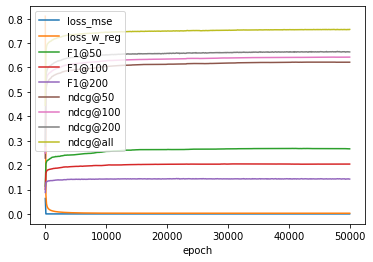

In [40]:
pd.set_option('display.max_rows', 500)
results_df = pd.DataFrame(results)
results_df.groupby(by=['epoch']).mean().plot()
results_df.groupby(by=['epoch']).mean()
# results_df.groupby(by=['epoch']).mean().iloc[-1]

In [44]:
# setting
lr = 0.5
momentum = 0.99
weight_decay = 0
nesterov = False # True

milestones = [5000, 1000, 15000]
gamma = 0.1

n_epoch = 50000

w_sum_reg = 1e-3
w_sum_reg_mul = 0.9
w_clip_value = 0


L1 = 1e-6

verbose = True
valid_epoch = 100


model = LR(num_doc=train_size, num_words=word_vectors.shape[0]).to(device)
model.train()

word_vectors_tensor = torch.FloatTensor(word_vectors).to(device)
w_reg = (torch.ones(batch_size, 1) * w_sum_reg_mul).to(device)
    
opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay, nesterov=nesterov)
scheduler = MultiStepLR(opt, milestones=milestones, gamma=gamma)

criterion = nn.MSELoss(reduction='mean')

results = []
step = 0
for epoch in tqdm(range(n_epoch)):    
    loss_mse_his = []
    loss_w_reg_his = []
    
    model.train()

    for data in train_loader:
        doc_embs, doc_w_sum, doc_ids = data
        
        doc_embs = doc_embs.to(device)
        doc_w_sum = doc_w_sum.to(device)
        doc_ids = doc_ids.to(device)
        # MSE loss
        pred_doc_embs = model(doc_ids, word_vectors_tensor)     
        loss_mse = criterion(pred_doc_embs, doc_embs)

        pred_w_sum = torch.sum(model.emb(doc_ids), axis=1).view(-1, 1)
        loss_w_reg = criterion(pred_w_sum, w_reg)
        
        loss_l1 = torch.sum(torch.abs(model.emb(doc_ids)))
        loss = loss_mse + loss_w_reg * w_sum_reg + loss_l1 * L1
        
        # Model backwarding
        model.zero_grad()
        loss.backward()
        opt.step()
        
        loss_mse_his.append(loss_mse.item())
        loss_w_reg_his.append(loss_w_reg.item())

        for p in model.parameters():
            p.data.clamp_(w_clip_value, float('inf'))

        
    if epoch % valid_epoch == 0:
        res = {}
        res['epoch'] = epoch
        res['loss_mse'] = np.mean(loss_mse_his)
        res['loss_w_reg'] = np.mean(loss_w_reg_his)
        
        res_ndcg = evaluate_NDCG(model, train_loader)
        res.update(res_ndcg)
        results.append(res)
        
        print()
        if verbose:
            for k, v in res.items():
                print(k, v)
                
    results.append(res)
    scheduler.step()

  0%|          | 0/50000 [00:00<?, ?it/s]


epoch 0
loss_mse 0.06314441561698914
loss_w_reg 0.8099998831748962
F1@50 0.1141413853279018
F1@100 0.10091427900082492
F1@200 0.08791059063494772
ndcg@50 0.22881080489313327
ndcg@100 0.24935128604334295
ndcg@200 0.2782097088431202
ndcg@all 0.44528800309058375

epoch 100
loss_mse 1.5685593098169193e-05
loss_w_reg 0.02965913712978363
F1@50 0.2218520824266498
F1@100 0.17908862788897167
F1@200 0.1338650899597483
ndcg@50 0.5420521854579134
ndcg@100 0.5656928215170938
ndcg@200 0.5935254752485908
ndcg@all 0.6934267573670412

epoch 200
loss_mse 3.7410447930597e-06
loss_w_reg 0.015533645637333393
F1@50 0.22986110846463517
F1@100 0.18347938779685374
F1@200 0.13645938093034693
ndcg@50 0.558362343425204
ndcg@100 0.5816729408657301
ndcg@200 0.6094558125591737
ndcg@all 0.7068824603893556

epoch 300
loss_mse 1.999543655983871e-06
loss_w_reg 0.010901477187871933
F1@50 0.2332172687205212
F1@100 0.1870398829725724
F1@200 0.13838213269797806
ndcg@50 0.5702762831117697
ndcg@100 0.5939637635929107
ndcg@20


epoch 3200
loss_mse 6.176060765028524e-07
loss_w_reg 0.0038939036894589663
F1@50 0.24877192418490002
F1@100 0.19559061326167906
F1@200 0.14217068557889015
ndcg@50 0.5955108418865881
ndcg@100 0.6193213308431522
ndcg@200 0.6453690944369993
ndcg@all 0.738110898700772

epoch 3300
loss_mse 6.140339792182203e-07
loss_w_reg 0.0038745510391891003
F1@50 0.24877192418490002
F1@100 0.19559061326167906
F1@200 0.14235748879429125
ndcg@50 0.5957716996975141
ndcg@100 0.6195913838946092
ndcg@200 0.6458309904644578
ndcg@all 0.7380898963850224

epoch 3400
loss_mse 6.106836849539832e-07
loss_w_reg 0.003855261718854308
F1@50 0.24855453288055218
F1@100 0.19575590251787742
F1@200 0.14249404777690558
ndcg@50 0.5956898572768703
ndcg@100 0.6197105605884881
ndcg@200 0.646114280877826
ndcg@all 0.7382369844944635

epoch 3500
loss_mse 6.075061946830829e-07
loss_w_reg 0.003836303250864148
F1@50 0.24855453288055218
F1@100 0.1959313411143686
F1@200 0.1423780744178735
ndcg@50 0.5957757895204678
ndcg@100 0.61996165252


epoch 6300
loss_mse 5.582700168815791e-07
loss_w_reg 0.0035814696457237005
F1@50 0.2492456101828216
F1@100 0.1969512324967129
F1@200 0.14274232805923698
ndcg@50 0.5971979024578757
ndcg@100 0.6218773336206431
ndcg@200 0.6481124426468869
ndcg@all 0.7396114365958393

epoch 6400
loss_mse 5.579835260505206e-07
loss_w_reg 0.003580142743885517
F1@50 0.24949877473978357
F1@100 0.1969512324967129
F1@200 0.1422613091950823
ndcg@50 0.5974332531279035
ndcg@100 0.6218811942740659
ndcg@200 0.6471997293842048
ndcg@all 0.73953947006366

epoch 6500
loss_mse 5.577488195740443e-07
loss_w_reg 0.003578772535547614
F1@50 0.24949877473978357
F1@100 0.1969512324967129
F1@200 0.14214356950688595
ndcg@50 0.597434632700174
ndcg@100 0.621883482996619
ndcg@200 0.6473094181123463
ndcg@all 0.739313261241787

epoch 6600
loss_mse 5.57489215680107e-07
loss_w_reg 0.003577433992177248
F1@50 0.24949877473978357
F1@100 0.1969512324967129
F1@200 0.14305327609308466
ndcg@50 0.5974373394532738
ndcg@100 0.6218872014183124
ndc


epoch 9500
loss_mse 5.49936203242396e-07
loss_w_reg 0.0035391231067478657
F1@50 0.2497804648806287
F1@100 0.19694007048331016
F1@200 0.14252813995198296
ndcg@50 0.5979947654929546
ndcg@100 0.6225440359495875
ndcg@200 0.6480575691987756
ndcg@all 0.7396676477494734

epoch 9600
loss_mse 5.496794415194017e-07
loss_w_reg 0.00353784067556262
F1@50 0.2497804648806287
F1@100 0.19694007048331016
F1@200 0.14271050025430407
ndcg@50 0.5979957374812451
ndcg@100 0.6225452709435184
ndcg@200 0.6483528533010449
ndcg@all 0.7398202435114696

epoch 9700
loss_mse 5.494201218425587e-07
loss_w_reg 0.003536555450409651
F1@50 0.2497804648806287
F1@100 0.19694007048331016
F1@200 0.14250713866184125
ndcg@50 0.5979984413461645
ndcg@100 0.6225477522258154
ndcg@200 0.6478194934418292
ndcg@all 0.7398168611956819

epoch 9800
loss_mse 5.491561410053691e-07
loss_w_reg 0.003535273252055049
F1@50 0.2497804648806287
F1@100 0.19694007048331016
F1@200 0.14292269548604838
ndcg@50 0.5980015108166864
ndcg@100 0.62255154727593


epoch 12600
loss_mse 5.420146180767915e-07
loss_w_reg 0.003500312799587846
F1@50 0.250097925198089
F1@100 0.1974387162225976
F1@200 0.14240337451567275
ndcg@50 0.5982333212762849
ndcg@100 0.6230876945477218
ndcg@200 0.6480877246075909
ndcg@all 0.7399562781086394

epoch 12700
loss_mse 5.417841180133109e-07
loss_w_reg 0.0034990855492651463
F1@50 0.250097925198089
F1@100 0.1974387162225976
F1@200 0.14252217790714852
ndcg@50 0.5982340226406947
ndcg@100 0.6230891048601804
ndcg@200 0.6486891106743061
ndcg@all 0.7400472703058124

epoch 12800
loss_mse 5.415550958787207e-07
loss_w_reg 0.003497849218547344
F1@50 0.250097925198089
F1@100 0.1974387162225976
F1@200 0.1429331913201307
ndcg@50 0.598237198317722
ndcg@100 0.6230925985016706
ndcg@200 0.6489039864944427
ndcg@all 0.7398522510192054

epoch 12900
loss_mse 5.413210715232708e-07
loss_w_reg 0.003496631281450391
F1@50 0.250097925198089
F1@100 0.1974387162225976
F1@200 0.1425846209894617
ndcg@50 0.5982466643514678
ndcg@100 0.6231025324020406
nd


epoch 15700
loss_mse 5.361386001823121e-07
loss_w_reg 0.0034717069938778877
F1@50 0.25038778027055275
F1@100 0.1974514609798679
F1@200 0.14286582313740426
ndcg@50 0.5985592257499046
ndcg@100 0.6232611198516186
ndcg@200 0.6489203372493758
ndcg@all 0.7401880568800847

epoch 15800
loss_mse 5.361093258215988e-07
loss_w_reg 0.003471601288765669
F1@50 0.25038778027055275
F1@100 0.1974514609798679
F1@200 0.1430391887532763
ndcg@50 0.5985592257499046
ndcg@100 0.6232615376673302
ndcg@200 0.6492075580684937
ndcg@all 0.7400494002735468

epoch 15900
loss_mse 5.360852810554206e-07
loss_w_reg 0.00347149302251637
F1@50 0.25038778027055275
F1@100 0.1974514609798679
F1@200 0.1425018844823299
ndcg@50 0.5985592257499046
ndcg@100 0.6232615376673302
ndcg@200 0.6480226475446506
ndcg@all 0.7397721447978899

epoch 16000
loss_mse 5.360611794458237e-07
loss_w_reg 0.003471381962299347
F1@50 0.25038778027055275
F1@100 0.1974514609798679
F1@200 0.1423479748932974
ndcg@50 0.5985592257499046
ndcg@100 0.623261537667


epoch 18800
loss_mse 5.35451306404866e-07
loss_w_reg 0.003468147711828351
F1@50 0.250647520530293
F1@100 0.19762095250529163
F1@200 0.14268636154869038
ndcg@50 0.5987104120055986
ndcg@100 0.623347865321016
ndcg@200 0.6486819133950461
ndcg@all 0.740491995273752

epoch 18900
loss_mse 5.354299332793744e-07
loss_w_reg 0.0034680329263210297
F1@50 0.250647520530293
F1@100 0.19762095250529163
F1@200 0.14269247774813495
ndcg@50 0.5987104120055986
ndcg@100 0.623347865321016
ndcg@200 0.6490150522649089
ndcg@all 0.740055080262998

epoch 19000
loss_mse 5.354092991183279e-07
loss_w_reg 0.0034679158125072718
F1@50 0.250647520530293
F1@100 0.19762095250529163
F1@200 0.14266096070294043
ndcg@50 0.5987104120055986
ndcg@100 0.623347865321016
ndcg@200 0.6486558580547434
ndcg@all 0.7401903863129148

epoch 19100
loss_mse 5.353870733415533e-07
loss_w_reg 0.003467799397185445
F1@50 0.250647520530293
F1@100 0.19762095250529163
F1@200 0.14207458099214684
ndcg@50 0.5987104120055986
ndcg@100 0.6233481576499398



epoch 21900
loss_mse 5.346885814105917e-07
loss_w_reg 0.0034646312706172466
F1@50 0.250647520530293
F1@100 0.19762095250529163
F1@200 0.1425893750357229
ndcg@50 0.5987104900979027
ndcg@100 0.6233506790709061
ndcg@200 0.6483422741054851
ndcg@all 0.740187970439459

epoch 22000
loss_mse 5.346626608115912e-07
loss_w_reg 0.0034645195119082928
F1@50 0.250647520530293
F1@100 0.19762095250529163
F1@200 0.1425612676080983
ndcg@50 0.5987104900979027
ndcg@100 0.6233506790709061
ndcg@200 0.6480976907676463
ndcg@all 0.7402937999751141

epoch 22100
loss_mse 5.346379339243867e-07
loss_w_reg 0.0034644054248929024
F1@50 0.250647520530293
F1@100 0.19762095250529163
F1@200 0.1426706143550228
ndcg@50 0.5987104900979027
ndcg@100 0.6233506790709061
ndcg@200 0.6484368551549028
ndcg@all 0.7401843372291941

epoch 22200
loss_mse 5.346134912542766e-07
loss_w_reg 0.003464293433353305
F1@50 0.250647520530293
F1@100 0.19762095250529163
F1@200 0.14238881264461944
ndcg@50 0.5987104900979027
ndcg@100 0.62335067907090


epoch 25000
loss_mse 5.339317112884601e-07
loss_w_reg 0.003461128333583474
F1@50 0.2508774055877643
F1@100 0.19780443874382378
F1@200 0.14295298945485482
ndcg@50 0.5991056553540537
ndcg@100 0.6234056085427342
ndcg@200 0.6488977653547926
ndcg@all 0.7404221444147023

epoch 25100
loss_mse 5.339076665222819e-07
loss_w_reg 0.0034610165748745203
F1@50 0.2508774055877643
F1@100 0.19780443874382378
F1@200 0.1434498553155142
ndcg@50 0.5991056553540537
ndcg@100 0.6234056085427342
ndcg@200 0.6491219280600211
ndcg@all 0.7402692302135969

epoch 25200
loss_mse 5.338834512258472e-07
loss_w_reg 0.003460903652012348
F1@50 0.2508774055877643
F1@100 0.19780443874382378
F1@200 0.14260786426584
ndcg@50 0.5991056553540537
ndcg@100 0.6234056085427342
ndcg@200 0.6479629875334828
ndcg@all 0.7397921664581633

epoch 25300
loss_mse 5.338579285307787e-07
loss_w_reg 0.0034607916604727507
F1@50 0.2508774055877643
F1@100 0.19780443874382378
F1@200 0.14258516719894518
ndcg@50 0.5991056553540537
ndcg@100 0.62340560854


epoch 28100
loss_mse 5.332206001185114e-07
loss_w_reg 0.003457617713138461
F1@50 0.2508774055877643
F1@100 0.19780443874382378
F1@200 0.1432148173135796
ndcg@50 0.5990976942784902
ndcg@100 0.6234009526984466
ndcg@200 0.6491384920983498
ndcg@all 0.7401616110507182

epoch 28200
loss_mse 5.331989996193442e-07
loss_w_reg 0.0034575057215988636
F1@50 0.2508774055877643
F1@100 0.19780443874382378
F1@200 0.14292404823100666
ndcg@50 0.5990976942784902
ndcg@100 0.6234017569253213
ndcg@200 0.6487941287651879
ndcg@all 0.740271365323691

epoch 28300
loss_mse 5.33175011696585e-07
loss_w_reg 0.0034573914017528296
F1@50 0.2508774055877643
F1@100 0.19780443874382378
F1@200 0.14285146777075805
ndcg@50 0.5990976942784902
ndcg@100 0.6234017569253213
ndcg@200 0.6485933036393067
ndcg@all 0.7403065763157148

epoch 28400
loss_mse 5.331528427632293e-07
loss_w_reg 0.0034572782460600138
F1@50 0.2508774055877643
F1@100 0.19780443874382378
F1@200 0.14266800551958617
ndcg@50 0.5990976942784902
ndcg@100 0.623401756


epoch 31200
loss_mse 5.325140364220715e-07
loss_w_reg 0.003454126650467515
F1@50 0.2508774055877643
F1@100 0.19780443874382378
F1@200 0.14278254804708562
ndcg@50 0.599113123145994
ndcg@100 0.6234203540526305
ndcg@200 0.6486628656055348
ndcg@all 0.7401181560439835

epoch 31300
loss_mse 5.32490560090082e-07
loss_w_reg 0.0034540160559117794
F1@50 0.2508774055877643
F1@100 0.19780443874382378
F1@200 0.1425934925945119
ndcg@50 0.599113123145994
ndcg@100 0.6234203540526305
ndcg@200 0.6483760864157527
ndcg@all 0.7406707724730155

epoch 31400
loss_mse 5.324674248186057e-07
loss_w_reg 0.003453903365880251
F1@50 0.2508774055877643
F1@100 0.19780443874382378
F1@200 0.14282471120392562
ndcg@50 0.599113123145994
ndcg@100 0.6234203540526305
ndcg@200 0.648856243373779
ndcg@all 0.740601955247083

epoch 31500
loss_mse 5.324430958353332e-07
loss_w_reg 0.003453792305663228
F1@50 0.2508774055877643
F1@100 0.19780443874382378
F1@200 0.1429383615107691
ndcg@50 0.599113123145994
ndcg@100 0.6234204149358552


KeyboardInterrupt: 

In [ ]:
pd.set_option('display.max_rows', 500)
results_df = pd.DataFrame(results)
results_df.groupby(by=['epoch']).mean().plot()
results_df.groupby(by=['epoch']).mean()
# results_df.groupby(by=['epoch']).mean().iloc[-1]

## Quality Check

In [31]:
# select doc_id and k
doc_id = 4
topk = 50

model

LR(
  (emb): Embedding(100, 13855)
)

In [32]:
import colored
from colored import stylize

word_list = dataset.vocab.itos

gt = [word_list[word_idx] for word_idx in np.argsort(weight_ans[doc_id])[::-1][:topk]]
pred = [word_list[word_idx] for word_idx in np.argsort(model.emb.cpu().weight.data[doc_id].numpy())[::-1][:topk]]

print('ground truth')
for word in gt:
    if word in pred:
        print(stylize(word, colored.bg("yellow")), end=' ')
    else:
        print(word, end=' ')

print()
print('\nprediction')
for word in pred:
    if word in gt:
        print(stylize(word, colored.bg("yellow")), end=' ')
    else:
        print(word, end=' ')


ground truth
warren rent flesh slapstick less fume cut lesli speak overal himself brook mel actress sailor price room ann cure overboard fujimori vessel walt 1947 distinguish employ 1924 pink vibrant dancer beset cork dual hail toll seiz slum idealist vosloo arnold gear jog jafar wee troll scatter tack plead 00 woke 

prediction
fume warren slapstick rent cut pay somewhat flesh speak bacon myself ill less cameo mix jim devote worker duller humor excess himself chuck broadway lower walk darker contempt uncut walter goldwyn kiarostami deeper coward steep jack eat bill tear lea moira patsi shaven cheh wood lavish deep upper william tarantino 

In [33]:
# raw document
dataset.documents[doc_id]

'this is not the typical mel brooks film .  it was much less slapstick than most of his movies and actually had a plot that was followable .  leslie ann warren made the movie ,  she is such a fantastic ,  under-rated actress .  there were some moments that could have been fleshed out a bit more ,  and some scenes that could probably have been cut to make the room to do so ,  but all in all ,  this is worth the price to rent and see it .  the acting was good overall ,  brooks himself did a good job without his characteristic speaking to directly to the audience .  again ,  warren was the best actor in the movie ,  but  " fume "  and  " sailor "  both played their parts well . '

In [34]:
results = {}
   
scores = np.array(model.emb.weight.data)[doc_id].reshape(1, -1)
true_relevance = train_loader.dataset.weight_ans[doc_id].reshape(1, -1)

results['ndcg@50'] = (ndcg_score(true_relevance, scores, k=50))
results['ndcg@100'] = (ndcg_score(true_relevance, scores, k=100))
results['ndcg@200'] = (ndcg_score(true_relevance, scores, k=200))
results['ndcg@all'] = (ndcg_score(true_relevance, scores, k=None))

print('NDCG top50', results['ndcg@50'])
print('NDCG top100', results['ndcg@100'])
print('NDCG top200', results['ndcg@200'])
print('NDCG ALL', results['ndcg@all'])


NDCG top50 0.7927611630070078
NDCG top100 0.8233342718307187
NDCG top200 0.8368919417569732
NDCG ALL 0.8526471735213274
